In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from kan import *
from kan import KAN
from kan.MLP import MLP
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
dtype = torch.get_default_dtype()

cpu


Loading IRIS dataset...
Train size: 120, Test size: 30
------------------------------
Training KAN on IRIS...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.21e-02 | test_loss: 9.42e-01 | reg: 6.53e+01 | : 100%|█| 20/20 [00:02<00:00,  8.76it


saving model version 0.1
Final KAN Test Accuracy: 0.9000
------------------------------
Training MLP on IRIS...


| train_loss: 3.50e-01 | test_loss: 3.55e-01 | reg: 3.64e+01 | : 100%|█| 20/20 [00:00<00:00, 27.97it


Final MLP Test Accuracy: 1.0000
------------------------------


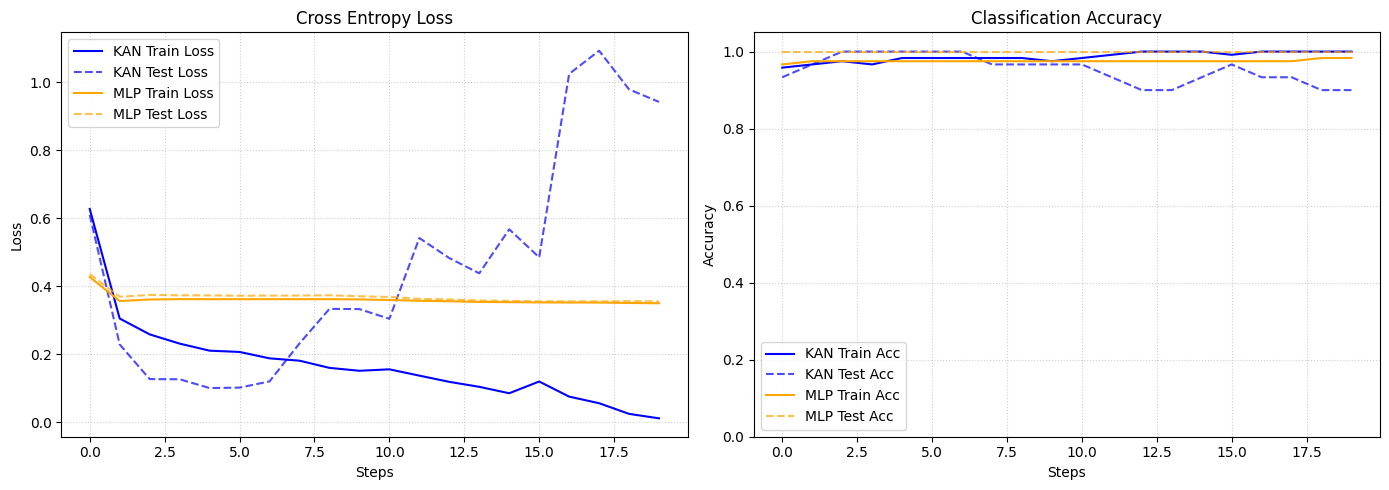

Automatic Symbolic Regression for KAN (Iris):
fixing (0,0,0) with x, r2=0.998406708240509, c=1
fixing (0,0,1) with x, r2=0.9999811053276062, c=1
fixing (0,0,2) with x, r2=0.39339330792427063, c=1
fixing (0,1,0) with x, r2=0.944534420967102, c=1
fixing (0,1,1) with x, r2=0.9996801018714905, c=1
fixing (0,1,2) with x, r2=0.32257330417633057, c=1
fixing (0,2,0) with x, r2=0.9996471405029297, c=1
fixing (0,2,1) with x, r2=0.9998714923858643, c=1
fixing (0,2,2) with x, r2=0.9990999102592468, c=1
fixing (0,3,0) with sin, r2=0.9999101758003235, c=2
fixing (0,3,1) with sin, r2=0.9994269013404846, c=2
fixing (0,3,2) with x, r2=0.6207794547080994, c=1
fixing (1,0,0) with x^2, r2=0.9985081553459167, c=2
fixing (1,0,1) with x^2, r2=0.9982383847236633, c=2
fixing (1,0,2) with x^2, r2=0.9983625411987305, c=2
fixing (1,1,0) with x, r2=0.44764813780784607, c=1
fixing (1,1,1) with x, r2=0.1384410411119461, c=1
fixing (1,1,2) with x, r2=0.26278042793273926, c=1
fixing (1,2,0) with x, r2=0.01187989953905

In [14]:
print("Loading IRIS dataset...")
iris = load_iris()
X = iris.data
y = iris.target

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create dataset dictionary expected by KAN/MLP
dataset_iris = {}
dtype = torch.get_default_dtype()

dataset_iris['train_input'] = torch.from_numpy(X_train).type(dtype).to(device)
dataset_iris['test_input'] = torch.from_numpy(X_test).type(dtype).to(device)
dataset_iris['train_label'] = torch.from_numpy(y_train).type(torch.long).to(device)  # Labels must be Long for CrossEntropy
dataset_iris['test_label'] = torch.from_numpy(y_test).type(torch.long).to(device)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print("-" * 30)

# --- 2. Train KAN Classifier ---
print("Training KAN on IRIS...")
# Architecture: 4 inputs -> 5 hidden neurons -> 3 output classes
kan_model = KAN(width=[4, 3, 3, 3], grid=5, k=3, seed=42, device=device)

# Define accuracy metrics
def train_acc_kan():
    return torch.mean((torch.argmax(kan_model(dataset_iris['train_input']), dim=1) == dataset_iris['train_label']).type(dtype))

def test_acc_kan():
    return torch.mean((torch.argmax(kan_model(dataset_iris['test_input']), dim=1) == dataset_iris['test_label']).type(dtype))

# Fit KAN
results_kan = kan_model.fit(
    dataset_iris,
    opt="LBFGS",
    steps=20,
    metrics=(train_acc_kan, test_acc_kan),
    loss_fn=torch.nn.CrossEntropyLoss()
)
print(f"Final KAN Test Accuracy: {results_kan['test_acc_kan'][-1]:.4f}")
print("-" * 30)

# --- 3. Train MLP Classifier ---
print("Training MLP on IRIS...")

# Architecture: 4 inputs -> 64 hidden neurons -> 3 output classes
mlp_model = MLP(width=[4, 64, 3], seed=42, device=device)

# Define MLP accuracy metrics (NEW)
def train_acc_mlp():
    return torch.mean((torch.argmax(mlp_model(dataset_iris['train_input']), dim=1) == dataset_iris['train_label']).type(dtype))

def test_acc_mlp():
    return torch.mean((torch.argmax(mlp_model(dataset_iris['test_input']), dim=1) == dataset_iris['test_label']).type(dtype))

# Fit MLP (Note: MLP.fit might not support 'metrics' tuple in older versions,
# so we calculate accuracy manually after training, but we pass loss_fn for classification)
results_mlp = mlp_model.fit(
    dataset_iris,
    opt="LBFGS",
    steps=20,
    lamb=0.01,
    metrics=(train_acc_mlp, test_acc_mlp), # Added metrics tracking
    loss_fn=torch.nn.CrossEntropyLoss()
)

# Calculate MLP Accuracy manually
#mlp_pred_test = torch.argmax(mlp_model(dataset_iris['test_input']), dim=1)
#mlp_acc = torch.mean((mlp_pred_test == dataset_iris['test_label']).type(dtype))
#print(f"Final MLP Test Accuracy: {mlp_acc:.4f}")
print(f"Final MLP Test Accuracy: {results_mlp['test_acc_mlp'][-1]:.4f}")
print("-" * 30)
new_plot = True
if new_plot:
    kan_res = results_kan
    mlp_res = results_mlp
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Plot 1: Loss ---
    axs[0].plot(kan_res['train_loss'], label='KAN Train Loss', color='blue')
    axs[0].plot(kan_res['test_loss'], label='KAN Test Loss', linestyle='--', color='blue', alpha=0.7)

    if isinstance(mlp_res, dict) and 'train_loss' in mlp_res:
        axs[0].plot(mlp_res['train_loss'], label='MLP Train Loss', color='orange')
        axs[0].plot(mlp_res['test_loss'], label='MLP Test Loss', linestyle='--', color='orange', alpha=0.7)

    axs[0].set_title("Cross Entropy Loss")
    axs[0].set_xlabel("Steps")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True, linestyle=':', alpha=0.6)

    # --- Plot 2: Accuracy ---
    # KAN Accuracy
    if 'train_acc_kan' in kan_res:
        axs[1].plot(kan_res['train_acc_kan'], label='KAN Train Acc', color='blue')
        axs[1].plot(kan_res['test_acc_kan'], label='KAN Test Acc', linestyle='--', color='blue', alpha=0.7)

    # MLP Accuracy
    if isinstance(mlp_res, dict) and 'train_acc_mlp' in mlp_res:
        axs[1].plot(mlp_res['train_acc_mlp'], label='MLP Train Acc', color='orange')
        axs[1].plot(mlp_res['test_acc_mlp'], label='MLP Test Acc', linestyle='--', color='orange', alpha=0.7)

    axs[1].set_title("Classification Accuracy")
    axs[1].set_xlabel("Steps")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True, linestyle=':', alpha=0.6)
    axs[1].set_ylim(0, 1.05) # Lock y-axis from 0 to 1 for clarity

    plt.tight_layout()
    plt.show()
else:
    # --- 4. Comparison Plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(results_kan['train_loss'], label='KAN Train Loss')
    plt.plot(results_kan['test_loss'], label='KAN Test Loss', linestyle='--')
    # MLP fit returns a list of losses directly in some versions, or a dict in others.
    # Assuming standard KAN lib return structure for MLP:
    if isinstance(results_mlp, dict) and 'train_loss' in results_mlp:
        plt.plot(results_mlp['train_loss'], label='MLP Train Loss')
        plt.plot(results_mlp['test_loss'], label='MLP Test Loss', linestyle='--')

    plt.title("Comparison: KAN vs MLP on IRIS Classification")
    plt.xlabel("Steps")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.show()

# --- 5. Symbolic Formula from KAN (Bonus) ---
print("Automatic Symbolic Regression for KAN (Iris):")
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
kan_model.auto_symbolic(lib=lib)
formula_iris = kan_model.symbolic_formula()[0]
print(f"Class 0 Formula (approx): {formula_iris[0]}")



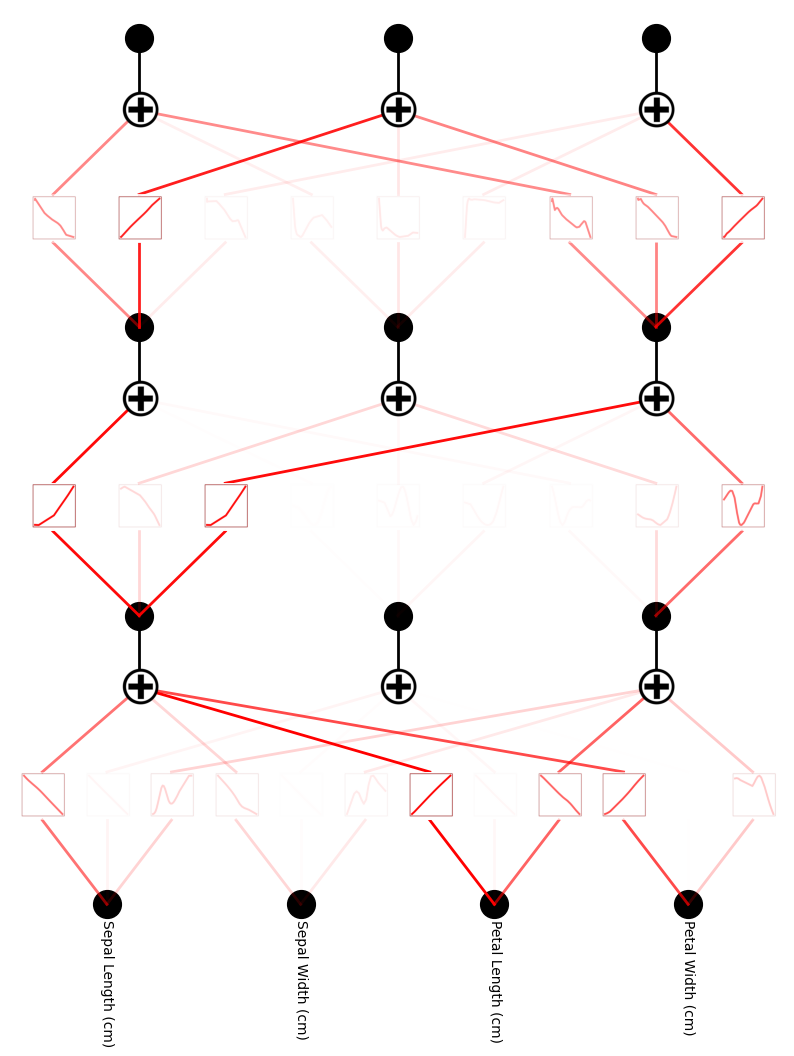

In [15]:
kan_model.plot(scale=1.0, beta=3)
n = 4
names = ["Sepal Length (cm)", "Sepal Width (cm)", "Petal Length (cm)", "Petal Width (cm)"]
for i in range(n):
    plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,names[i], rotation=270, rotation_mode="anchor")

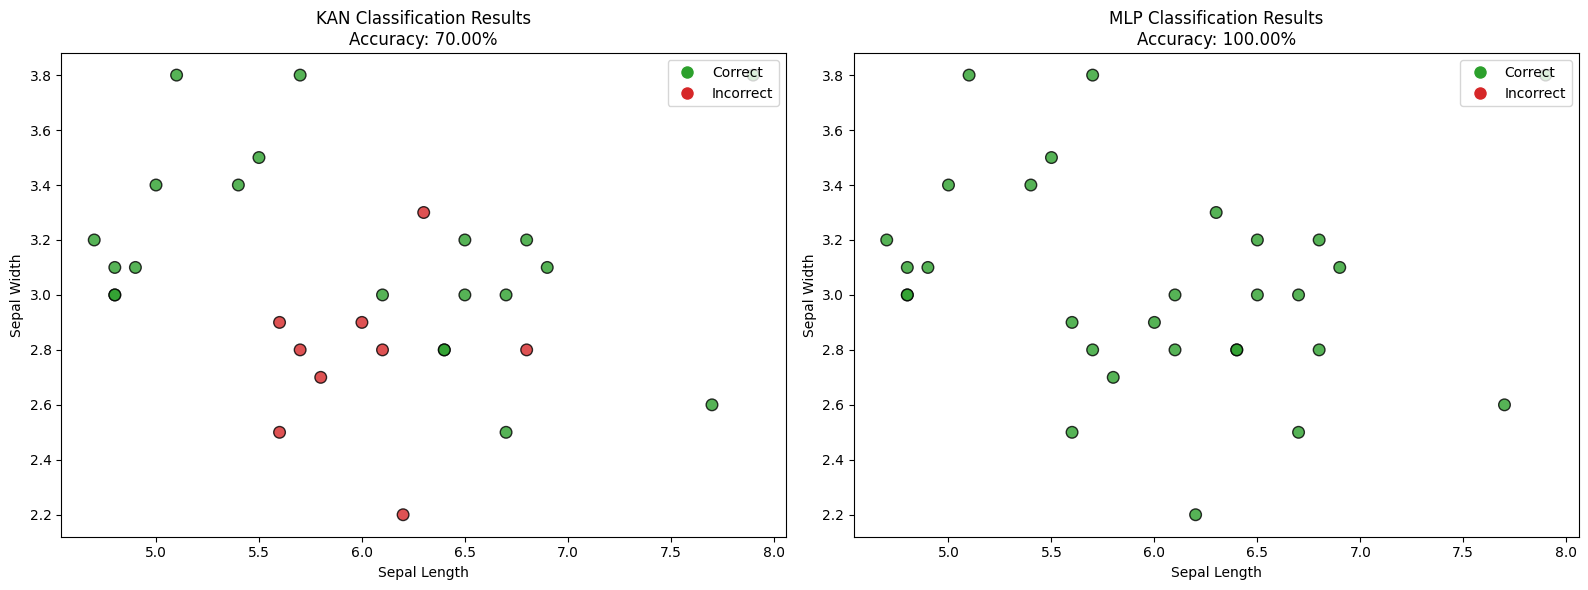

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_classification_results(kan_model, mlp_model, dataset):
    # 1. Get Data and Move to CPU
    X_test = dataset['test_input'].detach().cpu().numpy()
    y_test = dataset['test_label'].detach().cpu().numpy()

    # 2. Get Predictions
    # KAN
    kan_logits = kan_model(dataset['test_input'])
    kan_preds = torch.argmax(kan_logits, dim=1).detach().cpu().numpy()

    # MLP
    mlp_logits = mlp_model(dataset['test_input'])
    mlp_preds = torch.argmax(mlp_logits, dim=1).detach().cpu().numpy()

    # 3. Determine Correctness (Boolean masks)
    kan_correct = (kan_preds == y_test)
    mlp_correct = (mlp_preds == y_test)

    # 4. Setup Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Helper to map booleans to colors
    # Green (#2ca02c) for True, Red (#d62728) for False
    def get_colors(mask):
        return np.where(mask, '#2ca02c', '#d62728')

    # --- Plot KAN Results ---
    # Plotting Feature 0 (Sepal Length) vs Feature 1 (Sepal Width)
    axes[0].scatter(
        X_test[:, 0], X_test[:, 1],
        c=get_colors(kan_correct),
        s=70, alpha=0.8, edgecolors='k'
    )
    axes[0].set_title(f'KAN Classification Results\nAccuracy: {np.mean(kan_correct):.2%}')
    axes[0].set_xlabel('Sepal Length')
    axes[0].set_ylabel('Sepal Width')

    # Add legend manually for KAN
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', markersize=10, label='Correct'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', markersize=10, label='Incorrect')
    ]
    axes[0].legend(handles=legend_elements, loc='upper right')

    # --- Plot MLP Results ---
    axes[1].scatter(
        X_test[:, 0], X_test[:, 1],
        c=get_colors(mlp_correct),
        s=70, alpha=0.8, edgecolors='k'
    )
    axes[1].set_title(f'MLP Classification Results\nAccuracy: {np.mean(mlp_correct):.2%}')
    axes[1].set_xlabel('Sepal Length')
    axes[1].set_ylabel('Sepal Width')
    axes[1].legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# --- Run the function ---
plot_classification_results(kan_model, mlp_model, dataset_iris)